In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers,Sequential
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# 自定义参数
TRAIN_BUF = 60000
BATCH_SIZE = 128
TEST_BUF = 10000

#2.获取数据
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28).astype('float32')

# 标准化图片到区间 [0., 1.] 内
train_images /= 255.
test_images /= 255.

# 二值化，对数值像素进行伯努利分布建模
train_images[train_images >= .5] = 1.  #shape = (60000,28,28)
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

train_images = train_images.reshape((60000,784))
test_images  = test_images.reshape((10000,784))

# 添加椒盐噪音
SNR = 0.99

# 制作噪声面具，0表示原图不动
train_images_noise = train_images
test_images_noise = test_images

mask_train = np.random.choice((0,1,2),size=(60000,784),p=[SNR,(1-SNR)/2.,(1-SNR)/2.])
train_images_noise[mask_train==1]=1
train_images_noise[mask_train==2]=0

mask_test = np.random.choice((0,1,2),size=(10000,784),p=[SNR,(1-SNR)/2.,(1-SNR)/2.])
test_images_noise[mask_test==1]=1
test_images_noise[mask_test==2]=0

train_data = np.hstack((train_images,train_images_noise))
test_data = np.hstack((test_images,test_images_noise))



train_dataset = tf.data.Dataset.from_tensor_slices((train_data)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data)).shuffle(TEST_BUF).batch(BATCH_SIZE)




In [13]:
# 定义自己的模型
latent_dimension = 50

def split_image(input):
    return tf.split(input,num_or_size_splits=2,axis=-1)[1]

def sampling(agrs):
    mean,logvar = agrs[0],agrs[1]
    eps = tf.random.normal(tf.shape(mean))
    
    return mean + eps*tf.exp(logvar * 0.5)


# 编码阶段
    
x = layers.Input(shape=(784*2,)) 
    
h1 = layers.Dense(200,activation='softplus')(x)
h2 = layers.Dense(200,activation='softplus')(h1)
# 均值和方差层不需要激活函数
mean = layers.Dense(latent_dimension)(h2)
log_var = layers.Dense(latent_dimension)(h2)
    
# 将采样过程看成一个Lambda层
z = layers.Lambda(sampling,output_shape=(latent_dimension,))([mean,log_var])
    
# 解码阶段
h3 = layers.Dense(200,activation='softplus')
h4 = layers.Dense(200,activation='softplus')
h5 = layers.Dense(200,activation='softplus')
# No activation
end = layers.Dense(784)
z1 = h3(z)
z2 = h4(z1)
z3 = h5(z2)
out = end(z3)
    
# 建立模型
model = tf.keras.Model(x,out)
    
cross_ent = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.split(x,num_or_size_splits=2,axis=-1)[0],logits=out),axis=-1) # 重构误差
KL = -tf.reduce_sum(1+log_var-tf.square(mean)-tf.exp(log_var),axis=-1)
dvae_loss = tf.reduce_mean(cross_ent + KL)
model.add_loss(dvae_loss)

# 编译
model.compile(optimizer='adam')
# fit
history = model.fit(train_dataset,epochs=80,validation_data=test_dataset)    


Train for 469 steps, validate for 79 steps
Epoch 1/80
469/469 [==============================] - 7s 14ms/step - loss: 214.5413 - val_loss: 195.5533
Epoch 2/80
469/469 [==============================] - 6s 12ms/step - loss: 184.0655 - val_loss: 170.2627
Epoch 3/80
469/469 [==============================] - 6s 12ms/step - loss: 163.2238 - val_loss: 155.9035
Epoch 4/80
469/469 [==============================] - 6s 12ms/step - loss: 153.6012 - val_loss: 149.4357
Epoch 5/80
469/469 [==============================] - 6s 12ms/step - loss: 148.8887 - val_loss: 147.1980
Epoch 6/80
469/469 [==============================] - 6s 13ms/step - loss: 145.9180 - val_loss: 144.6943
Epoch 7/80
469/469 [==============================] - 6s 13ms/step - loss: 143.6698 - val_loss: 142.3454
Epoch 8/80
469/469 [==============================] - 6s 13ms/step - loss: 141.2227 - val_loss: 140.2317
Epoch 9/80
469/469 [==============================] - 6s 13ms/step - loss: 139.5984 - val_loss: 139.5667
Epoch 10/80


469/469 [==============================] - 6s 12ms/step - loss: 124.0204 - val_loss: 129.1632
Epoch 77/80
469/469 [==============================] - 6s 13ms/step - loss: 123.9339 - val_loss: 129.2126
Epoch 78/80
469/469 [==============================] - 6s 13ms/step - loss: 123.8996 - val_loss: 129.0574
Epoch 79/80
469/469 [==============================] - 6s 13ms/step - loss: 123.8350 - val_loss: 129.2545
Epoch 80/80
469/469 [==============================] - 6s 13ms/step - loss: 123.8044 - val_loss: 129.2562


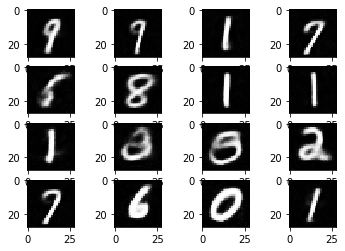

In [11]:
# 保存模型
model.save_weights('./self_vae')
# 构造生成器

decoder_input = layers.Input(shape=(latent_dimension,))
h1_decoder = h3(decoder_input) #200
h2_decoder = h4(h1_decoder)    #200
h3_decoder = h5(h2_decoder)    #200
decoder_output = end(h3_decoder) 

generator = tf.keras.Model(decoder_input,decoder_output)

# 从N(0,1)中采样16个图片
gussian_noise = tf.random.normal(shape=(16,latent_dimension))

# 预测
pred_from_sampling = generator.predict(gussian_noise)
pred_from_sampling = pred_from_sampling.reshape(16,28,28)
pred_from_sampling = tf.sigmoid(pred_from_sampling)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(pred_from_sampling[i,:,:],cmap='gray')



In [18]:
# 这两个值是从DVAE文件中获取
dvae_val_loss = [202.01180412195905, 176.28722526453717, 162.8188517123838, 154.1776385729826, 149.44736780094195, 145.76562190961235, 142.70156995556022, 141.50586845301373, 139.81038327760334, 139.09657133078272, 138.25378456598597, 137.65262188488924, 136.92440525489516, 136.42011985295935, 135.63587265980394, 135.1351062436647, 135.10460276543338, 134.5341337179836, 133.70417679412455, 133.1503778771509, 132.89547430110883, 132.33959709843504, 132.4230726217922, 131.78976643236376, 131.55719399754005, 131.7902791469912, 131.28998295264907, 131.0230031073848, 130.7957447872886, 130.5140571111365, 130.4399730827235, 130.54078403907485, 129.93043450464177, 130.4850177040583, 129.89095335368867, 129.83824012852924, 129.91223096243942, 129.65034996708738, 129.69457447679736, 129.78460838221295, 129.5206392505501, 129.2914870056925, 129.19918832899648, 129.52814628504498, 129.68566324741025, 129.58143876474114, 129.13891485672963, 129.01975491680676, 129.03575491603416, 128.77779127676277, 129.02767210368867, 128.88109492048432, 129.10440913333167, 128.9337253811993, 128.90074688875222, 129.0021670377707, 128.82494267330895, 128.36056277118152, 128.59210330625123, 128.82440330408795, 128.6315742202952, 128.7053174368943, 128.85702089720135, 128.37182105342043, 128.5021804616421, 128.36641615855544, 128.41754121418242, 128.44857227953173, 128.79705829861797, 128.4503768727749, 128.33377239372157, 128.1333749505538, 128.52103037773807, 128.3149010380612, 128.4061413535589, 128.44288905662827, 128.44442073001136, 128.3501152328298, 128.22721138483362, 128.41521695293957]
dvae_loss = [216.1392391845703, 187.57953724772136, 169.02913719889324, 159.3404215576172, 151.8862558186849, 147.67487659505207, 144.41699958496093, 142.31221014811197, 140.77565972493488, 139.4930682047526, 138.39803397623697, 137.49207661946613, 136.68166903483072, 135.89482975260415, 135.29900244954428, 134.66830839029947, 134.09521529134113, 133.59443518066405, 132.9585594156901, 132.3543864420573, 131.83755305175782, 131.26008505045573, 130.87128039957682, 130.4649085571289, 130.10161499837238, 129.80552200927735, 129.46279135742188, 129.17633147786458, 128.97009991861978, 128.71846091715494, 128.47022919921875, 128.21660834554035, 127.99384009195964, 127.8283644124349, 127.61971173502604, 127.45312195638022, 127.25368238932292, 127.0913486328125, 127.01025778401693, 126.79999802652995, 126.69724666341146, 126.51711142578125, 126.39315498046875, 126.2793189453125, 126.12088075764974, 126.02247019042969, 125.89602303059895, 125.76317263997396, 125.72301253255209, 125.57375192057292, 125.44356653238933, 125.37313005371094, 125.31065171305339, 125.17288037516276, 125.05023004150391, 125.00099391682943, 124.96805790201823, 124.8382587524414, 124.79949433186849, 124.67083313802084, 124.5779716796875, 124.46993221028646, 124.4349550008138, 124.35684884440104, 124.25997964274089, 124.18754069417318, 124.10752025960286, 124.01224927978515, 123.98773950602214, 123.95364635009766, 123.84231501057943, 123.79801430257162, 123.73473442789714, 123.67537377522787, 123.60375877685547, 123.59705156656901, 123.48523306884766, 123.44061397705079, 123.37814167073567, 123.26496649169921]

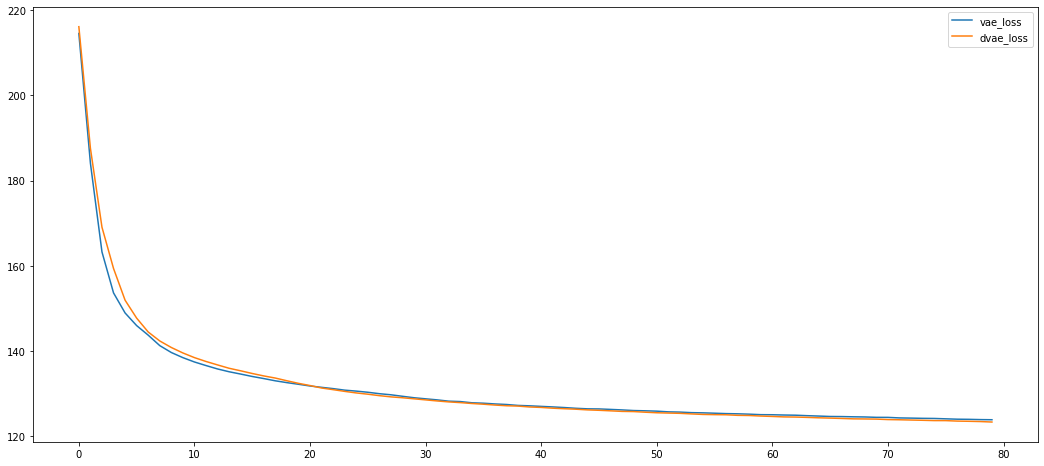

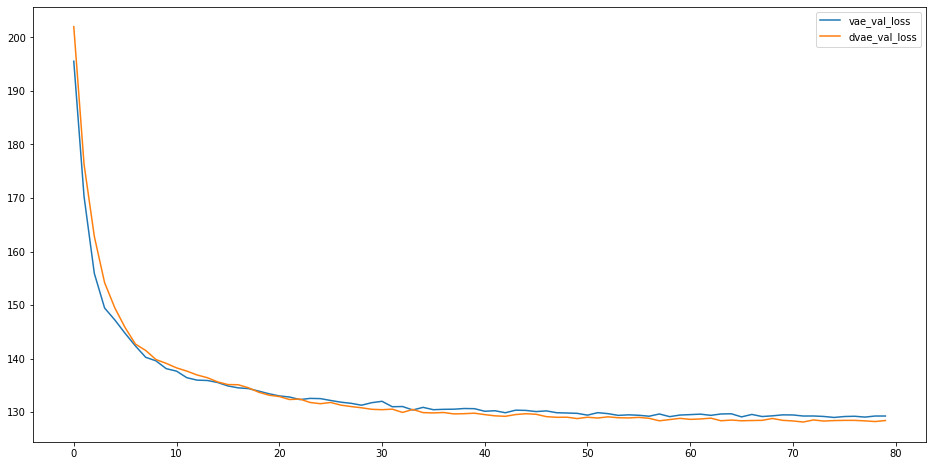

In [22]:

vae_loss = history.history['loss']
vae_val_loss = history.history['val_loss']
plt.figure(figsize = (18,8))
plt.plot(vae_loss,label='vae_loss')
plt.plot(dvae_loss,label='dvae_loss')
plt.legend()

plt.figure(figsize=(16,8))
plt.plot(vae_val_loss,label='vae_val_loss')
plt.plot(dvae_val_loss,label='dvae_val_loss')
plt.legend()

plt.show()

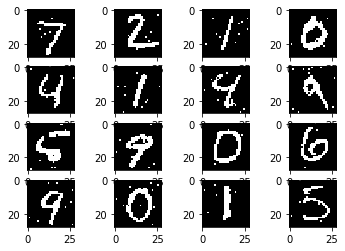

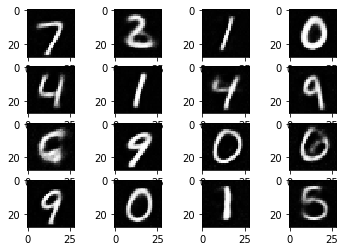

In [10]:
# 先把原始图片打印出来
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(test_images[i,:].reshape(28,28),cmap='gray')
    
# 再把预测的图像打印出来
plt.figure()

pred = model.predict(test_data[0:16,:])
pred = tf.reshape(pred,(16,28,28))
pred = tf.sigmoid(pred)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(pred[i,:,:],cmap='gray')